The work presented in this notebook is based on the paper:

`Depth optimization of quantum search algorithms beyond Grover’s algorithm` https://arxiv.org/abs/1908.04171 .

# Imports

In [1]:
# To install Qiskit, uncomment and run the line below
# !pip install -r requirements.txt --quiet

# If you haven't used your IBMQ account yet, load it using your TOKEN:
# IBMQ.save_account(TOKEN)

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt

# Qiskit imports
import qiskit
from qiskit import IBMQ, Aer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import transpile, execute
from qiskit.circuit.library import MCMT
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
import qiskit.tools.jupyter

# Provider and backends

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

In [3]:
backend_sim = Aer.get_backend('qasm_simulator')
backend_qc = provider.get_backend('ibmq_manila')
backend_qc_sim = QasmSimulator.from_backend(backend_qc)

# Analysis functions

In [4]:
def success_probabilities(counts, target1, target2):
    probs1 = []
    probs2 = []
    shots = sum(counts[0].values())
    for c in counts:
        probs1.append(c.get(target1, 0)/shots)
        probs2.append(c.get(target2, 0)/shots)
    return probs1, probs2

def selectivity(counts_lst, target1, target2):
    counts_lst = deepcopy(counts_lst)
    selec1 = []
    selec2 = []
    shots = sum(counts_lst[0].values())
    for c in counts_lst:
        p_t1 = c.get(target1, 0)/shots
        c.pop(target1)
        p_t2 = c.get(target2, 0)/shots
        c.pop(target2)
        if c == {}:
            p_hn = 1e-12
        else:
            p_hn = max(c.values())/shots
        selec1.append(10*np.log10(p_t1/p_hn))
        selec2.append(10*np.log10(p_t1/p_hn))
    return selec1, selec2

def plot_analysis(counts, target1, target2):
    probs1, probs2 = success_probabilities(counts, target1, target2)
    selec1, selec2 = selectivity(counts, target1, target2)
    
    a1 = probs1[0]
    theta1 = np.arcsin(np.sqrt(a1))
    a2 = probs2[0]
    theta2 = np.arcsin(np.sqrt(a2))
    
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize = (10, 5), constrained_layout=True)
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Prob. of measuring target state')
    axs[0].plot(probs1, '-o', label=target1)
    axs[0].plot(probs2, '-o', label=target2)
    axs[0].legend()
    axs[0].grid()
    
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Selectivity of target state')
    axs[1].plot(selec1, '-o', label=target1)
    axs[1].plot(selec2, '-o', label=target2)
    axs[1].axhline(y=3, c='k', ls='--', label='threshold')
    axs[1].legend()
    axs[1].grid()
    plt.plot()

# Depth optimization

Let's build our $\mathcal{A}$ and $\mathcal{A}^{\dagger}$ circuits.

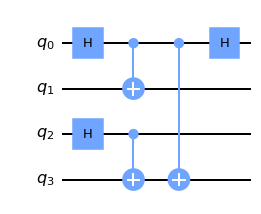

In [5]:
A = QuantumCircuit(4)
A.h([0, 2])
A.cx(0, 1)
A.cx(2, 3)
A.cx(0, 3)
A.h(0)
A.draw()

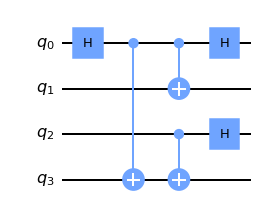

In [6]:
Adag = deepcopy(A.reverse_ops())
Adag.draw()

2 qubit diffusion operator

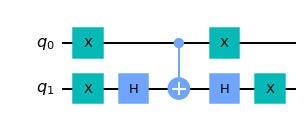

In [7]:
qr = QuantumRegister(2, 'q')
diff = QuantumCircuit(qr)
diff.x(qr)
diff.h(1)
diff.cnot(0, 1)
diff.h(1)
diff.x(qr)
diff.draw()

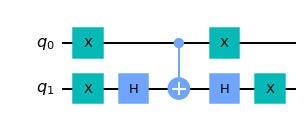

In [8]:
oracle = deepcopy(diff)
oracle.draw()

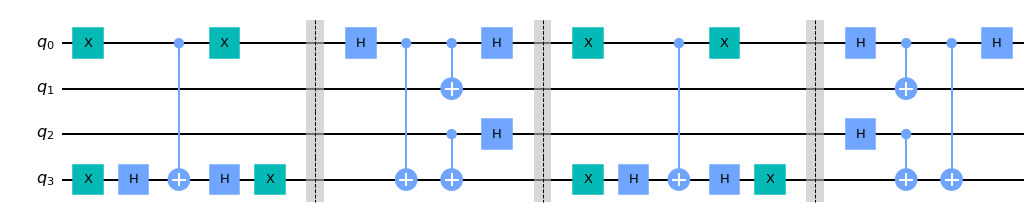

In [9]:
grover = QuantumCircuit(4)
grover.compose(oracle, [0, 3], inplace=True)
grover.barrier()
grover.compose(Adag, inplace=True)
grover.barrier()
grover.compose(diff, [0, 3], inplace=True)
grover.barrier()
grover.compose(A, inplace=True)
grover.draw()

In [10]:
grover = RemoveBarriers()(grover)

In [11]:
circ_lst = []

circ = QuantumCircuit(A.num_qubits)

circ.compose(A, inplace=True)
circ_temp = deepcopy(circ)
circ_temp.measure_all()
circ_lst.append(circ_temp)

for i in range(10):
    circ.compose(grover, inplace=True)
    circ_temp = deepcopy(circ)
    circ_temp.measure_all()
    circ_lst.append(circ_temp)

In [12]:
# job = execute(circ_lst, backend=backend_qc, shots=20000) # 61ce004d2ac6ddee4c4ccf63
# job = execute(circ_lst, backend=backend_qc, shots=20000, optimization_level=3) # 61ce00af049a237bb0d1e7c6
# job = backend_qc.retrieve_job('61c34f2dbf935fab23644d32')
job = backend_qc.retrieve_job('61ce004d2ac6ddee4c4ccf63')
counts = job.result().get_counts()

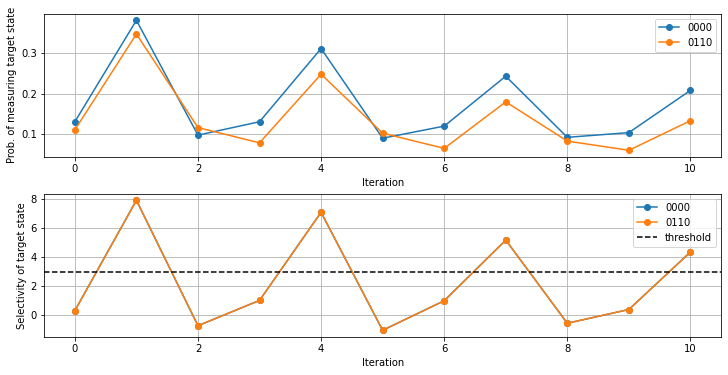

In [13]:
plot_analysis(counts, '0000', '0110')

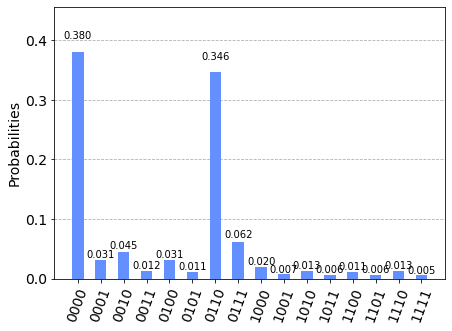

In [14]:
plot_histogram(counts[1])

Let's try to use a diferent oracle and diffusion operator in the second iteration.

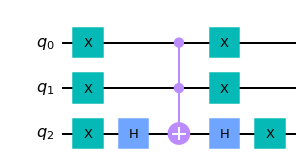

In [15]:
qr = QuantumRegister(3, 'q')
diff2 = QuantumCircuit(qr)
diff2.x(qr)
diff2.h(-1)
diff2.ccx(0, 1, 2)
diff2.h(-1)
diff2.x(qr)
diff2.draw()

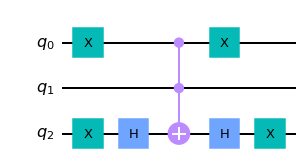

In [16]:
oracle2 = QuantumCircuit(3)
oracle2.x([0, -1])
oracle2.h(-1)
oracle2.ccx(0, 1, 2)
oracle2.h(-1)
oracle2.x([0, -1])
oracle2.draw()

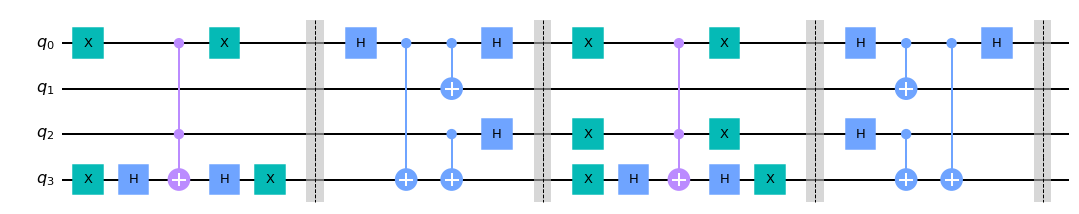

In [17]:
grover2 = QuantumCircuit(4)
grover2.compose(oracle2, [0, 2, 3], inplace=True)
grover2.barrier()
grover2.compose(Adag, inplace=True)
grover2.barrier()
grover2.compose(diff2, [0, 2, 3], inplace=True)
grover2.barrier()
grover2.compose(A, inplace=True)
grover2.barrier()
grover2.draw()

In [18]:
grover2 = RemoveBarriers()(grover2)

In [19]:
circ_lst = []

circ = QuantumCircuit(A.num_qubits)

# 0th iteration
circ.compose(A, inplace=True)
circ_temp = deepcopy(circ)
circ_temp.measure_all()
circ_lst.append(circ_temp)

# 1th iteration
circ.compose(grover, inplace=True)
circ_temp = deepcopy(circ)
circ_temp.measure_all()
circ_lst.append(circ_temp)

# 2th iteration
circ.compose(grover2, inplace=True)
circ_temp = deepcopy(circ)
circ_temp.measure_all()
circ_lst.append(circ_temp)

In [20]:
job = execute(circ_lst, backend=backend_qc_sim, shots=20000) # 61ce0460063519f0a5a7f86c
# job = execute(circ_lst, backend=backend_qc, shots=20000, optimization_level=3) # 61ce0464e867008868a03dfb
# job = backend_qc.retrieve_job('61ce0464e867008868a03dfb')
counts = job.result().get_counts()

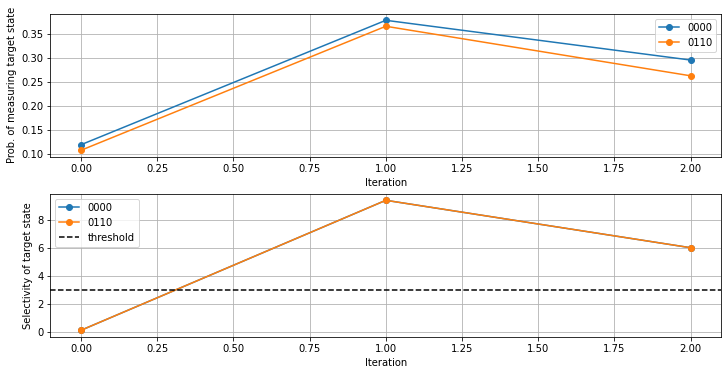

In [21]:
plot_analysis(counts, '0000', '0110')

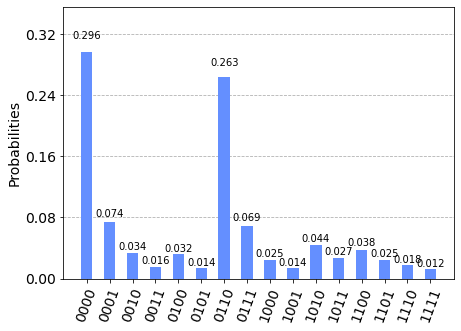

In [22]:
plot_histogram(counts[2])